# Austin, TX - Real Estate

## Introduction

Over the past ten years the city of Austin, TX went from being the 14th to the 11th most populous city in the United States. This growth is largely in part to the tech market which has grown by 25% over the past five years, making Austin the home to many tech giants, including Google, Facebook, Oracle, and Apple. This growth has also impacted surrounding areas like Georgetown, Cedar Park and Round Rock.
As the region grows, it is predicted between 3 and 4 million people will live in the 4 metro areas by 2040. Housing is expected to become more expensive and more compact as the population continues to grow.

## Bussiness Problem

Finding and purchasing a house is already a complicated process that involves a lot of variables. Some of those variables are price, which requires research through different websites and/or real state agents; location, the house should be in a good neighborhood with great gathering spots, parks, shops and a good school district. For this project we will look at real state data from Austin and it's surrounding areas to determine good deals for potential buyers  in this growing regions based on their requirements. 

## Data

The data needed for this project will include:
1. Zillow website data. Using the API from this real state website we can gather information about house prices, location, school districts, etc. 
2. FourSquare data. Using FourSquare API we can get information on the neighborhoods, including shops, restaurants, and venues around them.
3. City-data. Use this website to gather information about the city of Austin and its surrounding areas.

## Code

### Libraries

In [162]:
%matplotlib inline

import numpy as np
import pandas as pd
import requests
import re
import folium
import matplotlib as mpl
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup
import matplotlib.ticker as mticker
import matplotlib.cm as cm
import matplotlib.colors as colors
from uszipcode import SearchEngine
from uszipcode import Zipcode
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans

print('Libraries Imported!')

Libraries Imported!


### API Credentials 

In [83]:
# FourSquare credentials
CLIENT_ID = 'L3N0SIENRQLVO1BICAMBTCVA0ECKPBEAQOAG3RIN5CP0HOSL'
CLIENT_SECRET = '2NKZDNONPFTR1HPAU1DR1TYT2AJKRNJG0CC25NTLNE1OT44I'
VERSION = '20180604'
LIMIT = 100

### The Austin Area

#### Zip Codes
Here we get all the zip codes for the city of Austin, TX from city-data.com

In [206]:
# Austin zip codes
austin_zip = "http://www.city-data.com/zipmaps/Austin-Texas.html"
response = requests.get(austin_zip)

ziplist = []
# Parsing the results with BeautifulSoup
soup = BeautifulSoup(response.text, "html.parser")
table = soup.find_all('div', class_="zip data-block")
for t in table:
    ziplist.append(str(t["id"]))
    
print('Zip codes obtained!')
print(ziplist)

Zip codes obtained!
['78610', '78613', '78617', '78641', '78652', '78653', '78660', '78664', '78681', '78701', '78702', '78703', '78704', '78705', '78717', '78719', '78721', '78722', '78723', '78724', '78725', '78726', '78727', '78728', '78729', '78730', '78731', '78732', '78733', '78734', '78735', '78736', '78737', '78738', '78739', '78741', '78742', '78744', '78745', '78746', '78747', '78748', '78749', '78750', '78751', '78752', '78753', '78754', '78756', '78757', '78758', '78759']


#### House Prices
Get the average price of a house per zip code from zillow.com

In [4]:
headers = {
        'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
        'accept-encoding': 'gzip, deflate, br',
        'accept-language': 'en-US,en;q=0.9',
        'cache-control': 'max-age=0',
        'cookie': 'zguid=23|%24d14f0059-d03b-4422-9f57-5862fcd13490; _ga=GA1.2.1741285320.1590755697; zjs_user_id=null; zjs_anonymous_id=%22d14f0059-d03b-4422-9f57-5862fcd13490%22; __gads=ID=1050523ba93d593d:T=1590755700:S=ALNI_MZlJJ_xqSbd51oJisV_HY4g017Ehw; _gcl_au=1.1.2000298647.1590755705; KruxPixel=true; _fbp=fb.1.1590755705919.1815197270; _pxvid=d6c5ec75-a1a8-11ea-b8a9-0242ac120009; KruxAddition=true; JSESSIONID=3E7EBDB1F8931DF7D0DE9992546AE0B3; zgsession=1|200e23e0-9534-4d27-931f-caa3de6b483b; _gid=GA1.2.1328942480.1590858452; _gat=1; DoubleClickSession=true; GASession=true; _uetsid=fdde22d5-862a-8a7d-93e4-a16c574edf91; _pin_unauth=YzUyOGQ2OGMtMmQ3YS00NGZkLTg3MmEtOGJlODM1YWMwMTA1; _px3=026336d3721eec42bcdec3278ad2d3ac2014d5e65707b21624fb2e743d9a89be:mq3WRz2RNL5PBIvbYNHCxq5VfXHXy2YKC+8Lqn97pIw8MiKppH7Cx7AjKzbAFi1zcehKGY36aIgsnE9NiPKwlw==:1000:4U1o3ogIQ0KzfyMd2QYEFGDnD1augezy5bJlzEn9ZHE89B2uEIxDg8BmsGj8szPwyIz1Yv15S2V0TV5P+0jCFisfGk92XM4DM7K13GCtNr0HXhNGftVBFxVrCv8ApRphw/Qwj7AcagCh9i6FPiQGLFruxVASJXLsNpFeWimekVY=; AWSALB=ZKAGBcH2BwM6D1bRKOPynbOqyclySGz5U/fZB+wO3MYQ91UR9A5rFVtFsmjOkrMASUJguhtsJRZDM7IlBiWVT/pGw2S0BjxgEZmpFPrBZEqU2lWTE2NMArtecZD2; AWSALBCORS=ZKAGBcH2BwM6D1bRKOPynbOqyclySGz5U/fZB+wO3MYQ91UR9A5rFVtFsmjOkrMASUJguhtsJRZDM7IlBiWVT/pGw2S0BjxgEZmpFPrBZEqU2lWTE2NMArtecZD2; search=6|1593450465587%7Crect%3D40.843698984643765%252C-73.50417109960938%252C40.567821651427245%252C-74.45174190039063%26rid%3D6181%26disp%3Dmap%26mdm%3Dauto%26p%3D2%26z%3D0%26lt%3Dfsbo%26fs%3D1%26fr%3D0%26mmm%3D0%26rs%3D0%26ah%3D0%26singlestory%3D0%26housing-connector%3D0%26abo%3D0%26garage%3D0%26pool%3D0%26ac%3D0%26waterfront%3D0%26finished%3D0%26unfinished%3D0%26cityview%3D0%26mountainview%3D0%26parkview%3D0%26waterview%3D0%26hoadata%3D1%26zillow-owned%3D0%263dhome%3D0%09%096181%09%09%09%09%09%09',
        'sec-fetch-dest': 'document',
        'sec-fetch-mode': 'navigate',
        'sec-fetch-site': 'same-origin',
        'sec-fetch-user': '?1',
        'upgrade-insecure-requests': '1',
        'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.61 Safari/537.36'
    }

avg_price = []
change = []
forecast =[]

for z in ziplist:
  
    zillow = 'https://www.zillow.com/austin-tx-{}/home-values/'.format(z)
    response = requests.get(zillow, headers=headers)

    soup = BeautifulSoup(response.content, "html.parser")
    avg = soup.find_all('h2')
    avg_price.append(int(re.sub("[^\d\.]", "", avg[0].text)))
    change_list = soup.find_all('ul', class_='zsg-g')
    list_item = change_list[0].find_all('li')
    change.append(float(list_item[0].text.rpartition('%')[0]))   
    forecast.append(float(list_item[1].text.rpartition('%')[0]))

print('Zillow data obtained!')

Zillow data obtained!


Create a DataFrame with zip codes, average prices, 1-year change[%] and 1-year forecast[%

In [207]:
austin_df = pd.DataFrame(ziplist, columns=['Zip code'])
austin_df['Avg price'] = avg_price
austin_df['Change'] = change
austin_df['Forecast'] = forecast
austin_df.head()

,Zip code,Avg price,Change,Forecast
0,78610,300935,8.5,6.3
1,78613,368184,12.7,7.9
2,78617,240601,12.5,7.5
3,78641,324149,11.3,7.9
4,78652,400637,14.9,7.5


Since the change and forecast are shown as a percentage we can calculate the actual values a year prior and the expected value for next year based on the change and forecast values respectively. 

In [6]:
austin_year = pd.DataFrame()
austin_year['Zip code'] = austin_df['Zip code']
austin_year['2019'] = austin_df['Avg price'] - (austin_df['Avg price']*austin_df['Change']/100).astype(int)
austin_year['2020'] = austin_df['Avg price']
austin_year['2021'] = austin_df['Avg price'] + (austin_df['Avg price']*austin_df['Forecast']/100).astype(int)
austin_year.head()

,Zip code,2019,2020,2021
0,78610,275356,300935,319893
1,78613,321425,368184,397270
2,78617,210526,240601,258646
3,78641,287521,324149,349756
4,78652,340943,400637,430684


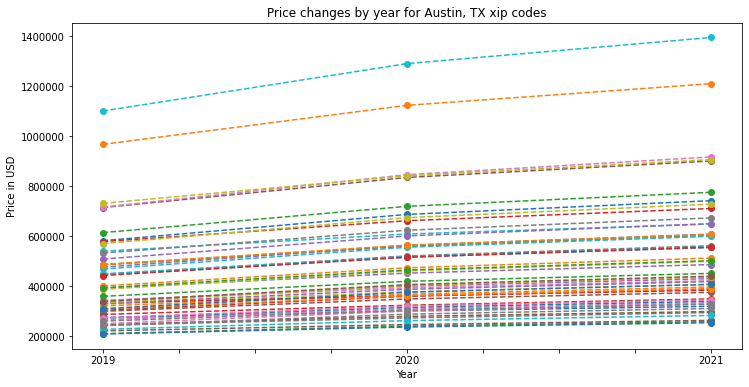

In [7]:
# Reshape data frame to plot prices zip code per year 
reshaped_df = pd.melt(austin_year, id_vars=['Zip code'], var_name='Year')
df = reshaped_df.pivot(index='Year', columns='Zip code', values='value')

# Plot data
ax = df.plot(kind='line', figsize=(12,6), linestyle='--', marker='o', grid=True)
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(False)
ax.set_title('Price changes by year for Austin, TX xip codes')
ax.set_ylabel('Price in USD')
ax.get_legend().remove()
plt.xticks(rotation=0)
plt.grid(linestyle='--')
plt.show()

It can be seen in the graph above that prices have increased for all zip codes in Austin, TX. 

#### Latitudes and Longitudes
We now need to get the latitude and longitude for all the zip codes using python's uszipcode library.

In [8]:
# setting the search engine
search = SearchEngine(simple_zipcode=True)
results = []

for z in ziplist:
    zipcode = search.by_zipcode(z)
    data = zipcode.to_dict()
    results.append(data)

# results dataframe    
austin_uszip_df = pd.json_normalize(results)
austin_lat_lon_df = austin_uszip_df[['zipcode','lat','lng']]
austin_lat_lon_df.rename(columns={'zipcode':'Zip code', 'lat':'Latitude', 'lng':'Longitude'}, inplace=True)
austin_lat_lon_df.head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Zip code,Latitude,Longitude
0,78610,30.10,-97.80
1,78613,30.50,-97.82
2,78617,30.15,-97.58
3,78641,30.50,-97.90
4,78652,30.13,-97.86


Now we can merge the two dataframes, and create one dataframe will the information we need. 

In [23]:
austin = pd.merge(austin_df, austin_lat_lon_df, how='inner', on='Zip code')
austin.drop(columns=['Change', 'Forecast'], inplace=True)
austin.dtypes

Zip code      object
Avg price      int64
Latitude     float64
Longitude    float64
dtype: object

In [11]:
address = 'Austin, TX'

geolocator = Nominatim(user_agent="_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 30.2711286, -97.7436995.


In [14]:
map_austin = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(austin['Latitude'], austin['Longitude'], austin['Zip code']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_austin) 
    
map_austin

### FourSquare API
Create a function that return the url for a specific location. 

In [97]:
def getUrl(n_lat, n_long, radius=3200): # Aprox. 2 mile radius
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    n_lat, 
    n_long, 
    radius, 
    LIMIT)
    return url

#### Test the function with the first location

In [98]:
n_postalcode, n_price, n_lat, n_long = austin.iloc[0]
print('Latitude and longitude values of {} are {}, {}.'.format(n_postalcode, 
                                                               n_lat, 
                                                               n_long))
results = requests.get(getUrl(n_lat,n_long)).json()
# results 

Latitude and longitude values of 78610 are 30.1, -97.8.


In [99]:
def getCatType(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Clean json file and store in pandas dataframe

In [208]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(getCatType, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Starbucks,Coffee Shop,30.090111,-97.816899
1,Chili's Grill & Bar,Tex-Mex Restaurant,30.084372,-97.823409
2,Hat Creek Burger Co.,Restaurant,30.083872,-97.824578
3,Dan's Hamburgers,Burger Joint,30.085976,-97.822469
4,Chick-fil-A,Fast Food Restaurant,30.083136,-97.823442


#### Obtaining data for all zip codes
Define a function to return the same information as above but this time for all the zip codes in the Austin area.

In [101]:
def getNearbyVenues(names, latitudes, longitudes, radius=3200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        LIMIT=100
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [102]:
austin_venues = getNearbyVenues(names=austin['Zip code'], 
                                   latitudes=austin['Latitude'], 
                                   longitudes=austin['Longitude'], 
                                   radius=3200)

78610
78613
78617
78641
78652
78653
78660
78664
78681
78701
78702
78703
78704
78705
78717
78719
78721
78722
78723
78724
78725
78726
78727
78728
78729
78730
78731
78732
78733
78734
78735
78736
78737
78738
78739
78741
78742
78744
78745
78746
78747
78748
78749
78750
78751
78752
78753
78754
78756
78757
78758
78759


In [103]:
print(austin_venues.shape)
austin_venues.head()

(3306, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,78610,30.1,-97.8,Starbucks,30.090111,-97.816899,Coffee Shop
1,78610,30.1,-97.8,Chili's Grill & Bar,30.084372,-97.823409,Tex-Mex Restaurant
2,78610,30.1,-97.8,Hat Creek Burger Co.,30.083872,-97.824578,Restaurant
3,78610,30.1,-97.8,Dan's Hamburgers,30.085976,-97.822469,Burger Joint
4,78610,30.1,-97.8,Chick-fil-A,30.083136,-97.823442,Fast Food Restaurant


#### Venues for each neighborhood

In [104]:
austin_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
78610,39,39,39,39,39,39
78613,100,100,100,100,100,100
78617,5,5,5,5,5,5
78641,12,12,12,12,12,12
78652,13,13,13,13,13,13
78653,4,4,4,4,4,4
78660,50,50,50,50,50,50
78664,100,100,100,100,100,100
78681,69,69,69,69,69,69


In [105]:
print('There are {} uniques categories.'.format(len(austin_venues['Venue Category'].unique())))

There are 308 uniques categories.


#### Analysis of each postal code

In [106]:
# one hot encoding
austin_onehot = pd.get_dummies(austin_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
austin_onehot['Neighborhood'] = austin_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [austin_onehot.columns[-1]] + list(austin_onehot.columns[:-1])
austin_onehot = austin_onehot[fixed_columns]

print(austin_onehot.shape)
austin_onehot.head()

(3306, 309)


,Neighborhood,Adult Boutique,Advertising Agency,African Restaurant,Airport,Airport Service,American Restaurant,Antique Shop,Arcade,Art Gallery,...,Vietnamese Restaurant,Warehouse Store,Water Park,Waterfall,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,78610,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,78610,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,78610,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,78610,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,78610,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Grouping rows by zip code
we take the frequency of each category by zip code

In [107]:
austin_grouped = austin_onehot.groupby('Neighborhood').mean().reset_index()
austin_grouped

,Neighborhood,Adult Boutique,Advertising Agency,African Restaurant,Airport,Airport Service,American Restaurant,Antique Shop,Arcade,Art Gallery,...,Vietnamese Restaurant,Warehouse Store,Water Park,Waterfall,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,78610,0.000000,0.00,0.00,0.000000,0.000000,0.051282,0.00,0.025641,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000
1,78613,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.010000,0.010000,0.00,0.000000,0.010000,0.00,0.000000,0.010000,0.00,0.000000
2,78617,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000
3,78641,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000
4,78652,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000
5,78653,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000
6,78660,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000
7,78664,0.000000,0.00,0.00,0.000000,0.000000,0.010000,0.00,0.000000,0.000000,...,0.010000,0.000000,0.01,0.000000,0.000000,0.00,0.000000,0.020000,0.00,0.000000
8,78681,0.000000,0.00,0.00,0.000000,0.000000,0.057971,0.00,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000
9,78701,0.000000,0.00,0.00,0.000000,0.000000,0.030000,0.00,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.010000,0.00,0.000000,0.000000,0.00,0.010000


#### Top 5 venue categories per zip code

In [109]:
num_top_venues = 5

for hood in austin_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = austin_grouped[austin_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----78610----
                  venue  freq
0           Pizza Place  0.10
1                 Hotel  0.10
2  Fast Food Restaurant  0.08
3          Burger Joint  0.08
4   American Restaurant  0.05


----78613----
                  venue  freq
0    Mexican Restaurant  0.09
1             BBQ Joint  0.04
2          Burger Joint  0.04
3           Coffee Shop  0.04
4  Fast Food Restaurant  0.04


----78617----
              venue  freq
0         Racetrack   0.2
1     Garden Center   0.2
2  Recording Studio   0.2
3            Market   0.2
4       Music Store   0.2


----78641----
                 venue  freq
0                  Bar  0.17
1            Gun Range  0.08
2  Arts & Crafts Store  0.08
3      Paintball Field  0.08
4       Sandwich Place  0.08


----78652----
                    venue  freq
0      Mexican Restaurant  0.31
1          Hardware Store  0.08
2  Thrift / Vintage Store  0.08
3                    Park  0.08
4             Gas Station  0.08


----78653----
                venue  f

#### Store in dataframe

In [111]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Create dataframe with top 10 venues in each postal code

In [131]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = austin_grouped['Neighborhood']

for ind in np.arange(austin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(austin_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,78610,Pizza Place,Hotel,Fast Food Restaurant,Burger Joint,Price,American Restaurant,Fried Chicken Joint,Big Box Store,Gym / Fitness Center,Boutique
1,78613,Price,Mexican Restaurant,Pizza Place,BBQ Joint,Burger Joint,Coffee Shop,Fast Food Restaurant,Pharmacy,Donut Shop,Sandwich Place
2,78617,Racetrack,Market,Music Store,Garden Center,Recording Studio,Price,Pool Hall,Nail Salon,Noodle House,Print Shop
3,78641,Bar,Park,Lake,Burger Joint,Tex-Mex Restaurant,Paintball Field,Liquor Store,Gun Range,Sandwich Place,Harbor / Marina
4,78652,Mexican Restaurant,Price,Pizza Place,Music Venue,Gas Station,Locksmith,Park,Hardware Store,Dive Bar,Thrift / Vintage Store


In [132]:
neighborhoods_venues_sorted.rename(columns = {'Neighborhood':'Zip code'}, inplace = True)

#### Add average price to dataframe

In [133]:
austin_grouped['Price'] = austin['Avg price']
v= austin_grouped.iloc[:, -1]
austin_grouped.iloc[:,-1] = (v - v.min()) / (v.max() - v.min())

### Clustering zip codes

In [170]:
kclusters = 3

austin_grouped_clustering = austin_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(austin_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

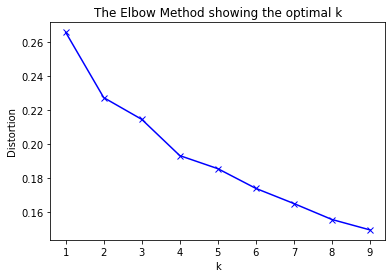

In [171]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(austin_grouped_clustering)
    kmeanModel.fit(austin_grouped_clustering)
    distortions.append(sum(np.min(cdist(austin_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / austin_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [172]:
neighborhoods_venues_sorted.drop(columns = 'Cluster Labels', inplace = True)

In [173]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

austin_merged = austin

austin_merged = austin_merged.join(neighborhoods_venues_sorted.set_index('Zip code'), on='Zip code')

austin_merged

,Zip code,Avg price,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,78610,300935,30.10,-97.80,0,Pizza Place,Hotel,Fast Food Restaurant,Burger Joint,Price,American Restaurant,Fried Chicken Joint,Big Box Store,Gym / Fitness Center,Boutique
1,78613,368184,30.50,-97.82,0,Price,Mexican Restaurant,Pizza Place,BBQ Joint,Burger Joint,Coffee Shop,Fast Food Restaurant,Pharmacy,Donut Shop,Sandwich Place
2,78617,240601,30.15,-97.58,0,Racetrack,Market,Music Store,Garden Center,Recording Studio,Price,Pool Hall,Nail Salon,Noodle House,Print Shop
3,78641,324149,30.50,-97.90,0,Bar,Park,Lake,Burger Joint,Tex-Mex Restaurant,Paintball Field,Liquor Store,Gun Range,Sandwich Place,Harbor / Marina
4,78652,400637,30.13,-97.86,0,Mexican Restaurant,Price,Pizza Place,Music Venue,Gas Station,Locksmith,Park,Hardware Store,Dive Bar,Thrift / Vintage Store
5,78653,246730,30.30,-97.50,0,Park,Trail,Miscellaneous Shop,Disc Golf,Price,Nature Preserve,Organic Grocery,Office,Noodle House,Nightclub
6,78660,309582,30.43,-97.60,0,Pizza Place,Pharmacy,Price,Coffee Shop,Grocery Store,Gas Station,Cosmetics Shop,Bar,Video Store,Mexican Restaurant
7,78664,273312,30.50,-97.64,0,Fast Food Restaurant,Sandwich Place,Pizza Place,Convenience Store,Gym,Video Store,Pharmacy,Price,Liquor Store,Coffee Shop
8,78681,377831,30.53,-97.72,0,Price,Gas Station,Mexican Restaurant,Pizza Place,American Restaurant,Pharmacy,Park,Hotel,Convenience Store,BBQ Joint
9,78701,608846,30.27,-97.74,0,Price,Hotel,Grocery Store,Food Truck,Coffee Shop,Cocktail Bar,BBQ Joint,Movie Theater,Seafood Restaurant,Restaurant


In [174]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(austin_merged['Latitude'],austin_merged['Longitude'], austin_merged['Zip code'], austin_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Price points (Low, Intermediate, High)

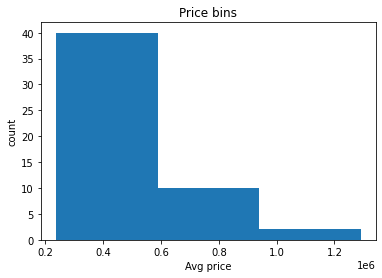

In [183]:
plt.hist(austin_merged["Avg price"],bins=3)
plt.xlabel("Avg price")
plt.ylabel("Counts")
plt.title("Price bins")
plt.show()

In [185]:
bins = np.linspace(min(austin_merged["Avg price"]), max(austin_merged["Avg price"]), 4)
bins

array([ 237076.        ,  588156.33333333,  939236.66666667,
       1290317.        ])

In [186]:
group_names = ['Low', 'Intermediate', 'High']

In [188]:
austin_merged['Price-Categories'] = pd.cut(austin_merged['Avg price'], bins, labels=group_names, include_lowest=True )
austin_merged[['Avg price','Price-Categories']].head()

,Avg price,Price-Categories
0,300935,Low
1,368184,Low
2,240601,Low
3,324149,Low
4,400637,Low


### Choropleth Visualization

In [197]:
aus_geo = './austin_area_zip_codes.geojson'
aus_map = folium.Map(location = [latitude, longitude], zoom_start = 11)

aus_map.choropleth(
    geo_data=aus_geo,
    data=austin_merged,
    columns=['Zip code','Avg price'],
    key_on='feature.properties.zipcode',
    fill_color='RdPu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average house Prices'
)
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(austin_merged['Latitude'],austin_merged['Longitude'], austin_merged['Zip code'], austin_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(aus_map)
       
# display map
aus_map

### Cluster 1 analysis

In [199]:
austin_merged[austin_merged['Cluster Labels']==0]

,Zip code,Avg price,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Price-Categories
0,78610,300935,30.10,-97.80,0,Pizza Place,Hotel,Fast Food Restaurant,Burger Joint,Price,American Restaurant,Fried Chicken Joint,Big Box Store,Gym / Fitness Center,Boutique,Low
1,78613,368184,30.50,-97.82,0,Price,Mexican Restaurant,Pizza Place,BBQ Joint,Burger Joint,Coffee Shop,Fast Food Restaurant,Pharmacy,Donut Shop,Sandwich Place,Low
2,78617,240601,30.15,-97.58,0,Racetrack,Market,Music Store,Garden Center,Recording Studio,Price,Pool Hall,Nail Salon,Noodle House,Print Shop,Low
3,78641,324149,30.50,-97.90,0,Bar,Park,Lake,Burger Joint,Tex-Mex Restaurant,Paintball Field,Liquor Store,Gun Range,Sandwich Place,Harbor / Marina,Low
4,78652,400637,30.13,-97.86,0,Mexican Restaurant,Price,Pizza Place,Music Venue,Gas Station,Locksmith,Park,Hardware Store,Dive Bar,Thrift / Vintage Store,Low
5,78653,246730,30.30,-97.50,0,Park,Trail,Miscellaneous Shop,Disc Golf,Price,Nature Preserve,Organic Grocery,Office,Noodle House,Nightclub,Low
6,78660,309582,30.43,-97.60,0,Pizza Place,Pharmacy,Price,Coffee Shop,Grocery Store,Gas Station,Cosmetics Shop,Bar,Video Store,Mexican Restaurant,Low
7,78664,273312,30.50,-97.64,0,Fast Food Restaurant,Sandwich Place,Pizza Place,Convenience Store,Gym,Video Store,Pharmacy,Price,Liquor Store,Coffee Shop,Low
8,78681,377831,30.53,-97.72,0,Price,Gas Station,Mexican Restaurant,Pizza Place,American Restaurant,Pharmacy,Park,Hotel,Convenience Store,BBQ Joint,Low
9,78701,608846,30.27,-97.74,0,Price,Hotel,Grocery Store,Food Truck,Coffee Shop,Cocktail Bar,BBQ Joint,Movie Theater,Seafood Restaurant,Restaurant,Intermediate


### Cluster 2 analysis

In [201]:
austin_merged[austin_merged['Cluster Labels']==1]

,Zip code,Avg price,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Price-Categories
43,78750,516209,30.41,-97.8,1,Park,Price,Trail,Outdoor Sculpture,Organic Grocery,Office,Noodle House,Nightclub,New American Restaurant,Nature Preserve,Low


### Cluster 3 analysis

In [202]:
austin_merged[austin_merged['Cluster Labels']==2]

,Zip code,Avg price,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Price-Categories
11,78703,1123513,30.29,-97.77,2,Price,Grocery Store,Mexican Restaurant,Park,Sandwich Place,American Restaurant,Café,Coffee Shop,Bar,Juice Bar,High
12,78704,719663,30.24,-97.75,2,Price,Coffee Shop,Vietnamese Restaurant,Food Truck,Taco Place,Hotel,Park,Restaurant,New American Restaurant,Beer Garden,Intermediate
25,78730,835014,30.37,-97.84,2,Price,Park,Athletics & Sports,Gas Station,Gastropub,Golf Course,Bookstore,Gym,Trail,Health & Beauty Service,Intermediate
26,78731,846130,30.35,-97.77,2,Price,Mexican Restaurant,Park,Coffee Shop,Food Truck,Gym,Pizza Place,Ice Cream Shop,Chinese Restaurant,Grocery Store,Intermediate
27,78732,624089,30.38,-97.89,2,Price,Coffee Shop,Park,Golf Course,Automotive Shop,Shipping Store,Sushi Restaurant,Salon / Barbershop,Gym,Supermarket,Intermediate
28,78733,841806,30.32,-97.87,2,Price,Golf Course,Park,Food Truck,Lake,Café,Food,Gas Station,Grocery Store,Trail,Intermediate
30,78735,687315,30.27,-97.87,2,Price,Golf Course,Resort,American Restaurant,Sporting Goods Shop,Flower Shop,Gas Station,Gym,Gymnastics Gym,Athletics & Sports,Intermediate
33,78738,662163,30.31,-97.98,2,Price,Mexican Restaurant,Baseball Field,Salon / Barbershop,Pharmacy,Coffee Shop,Restaurant,Rental Car Location,Discount Store,Pool,Intermediate
39,78746,1290317,30.30,-97.81,2,Price,Coffee Shop,Pizza Place,Sandwich Place,Bank,Mexican Restaurant,Juice Bar,Shipping Store,Gym / Fitness Center,Gym,High
48,78756,674323,30.32,-97.74,2,Price,Coffee Shop,Pizza Place,Burger Joint,Ice Cream Shop,Sandwich Place,Bakery,Park,Italian Restaurant,Taco Place,Intermediate
